In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import time

from joblib import Parallel, delayed, cpu_count
from matplotlib import cm

# Methods

In [2]:
def box(x,xlim):
    if x>max(xlim):
        return max(xlim)
    elif x<min(xlim):
        return min(xlim)
    else:
        return x

In [3]:
def maxminoptimizer_eq12(x, y0, lambda0, tau, beta, epsilon=0.01):
    t = 0
    pg = 1000
    lambda_ = 0.1#lambda0
    y_ = y0
    while np.linalg.norm(pg) > epsilon:
        lamb = lambda_
        y = y_

        lambda_ = lamb + beta*(y - x)
        y_ = y - tau*(dgy(x,y) + lamb)

        lambda_ = max(lambda_, 0) # Lambda must always be positive

        pg = 1/beta*((lamb - lambda_) + (y-y_))
        t += 1
    return y, lamb

def maxminoptimizer_eq13(x, y0, lambda0, lambda_opt, gam, tau, beta, epsilon=0.01):
    t = 0
    pg = 1000
    lambda_ = lambda0
    y_ = y0
    while np.linalg.norm(pg) > epsilon:
        lamb = lambda_
        y = y_

        lambda_ = lamb + beta*(y - x)
        y_ = y - tau*(dfy(x,y) + gam*(dgy(x, y) ) + lamb)

        lambda_ = max(lambda_, 0) # Lambda must always be positive

        pg = 1/beta*((lamb - lambda_) + (y-y_))
        t += 1
    return y, lamb

def solveF(x0,y0,lambda0,alpha,gam,beta,tau,xlim,epsilon=0.01,max_iters=10000):
    ls=[]
    pg = 1000
    pgs=[]
    x_ = box(x0,xlim)
    y_g = y0
    k=0
    
    xs = []
    ys = []
    lambdas = []

    dfxs = []
    dgxs_yf = []
    dgxs_yg = []

    while np.linalg.norm(pg) > epsilon and k < max_iters:
        x=x_
        y=y_g
        
        y_g, lambda_g = maxminoptimizer_eq12(x, y, lambda0, tau, beta, epsilon)
        y_F, lambda_F = maxminoptimizer_eq13(x, y_g, lambda0, lambda_g, gam, tau, beta, epsilon)
        
        dF = dfx(x,y_F)

        dfxs.append(dF)
                
        x_ = box(x-alpha*(dF + gam*(dgx(x, y_F) - dgx(x, y_g) + lambda_g) - lambda_F),xlim)
        dgxs_yf.append(dgx(x, y_F))
        dgxs_yg.append(dgx(x, y_g))
        pg=1/alpha*np.array([x-x_,y-y_g])
        
        pgs.append(float(np.linalg.norm(pg)))
        ls.append(float(np.abs(y+x)))

        xs.append(x_)
        ys.append(y_g)
        lambdas.append(lambda_g)
        k+=1
    return (x,y_F,k), (pgs, ls, xs, ys, lambdas), (dfxs, dgxs_yf, dgxs_yg)

In [4]:
def run_exp(i, gam, beta, tau, alpha,epsilon=1e-4):

    x=np.random.uniform(0,3.5)
    y=np.random.uniform(-5,8.5)
    lamb = np.random.uniform(0, 10)
    
    try:
        t_start = time.time()
        (x,y,k), _, _ = solveF(x,y,lamb,alpha,gam,beta,tau,xlim,epsilon,max_iters=500)
        t_elapsed = (time.time() - t_start)
    except OverflowError:
        x = -1
        y = -1
        k = -1
        t_elapsed = -1

    return x, y, k, t_elapsed

# Toy example 1

In [5]:
def g(x, y):
    return (y-2*x)**2

def dgx(x,y):
    return -4*(y-2*x)

def dgy(x,y):
    return 2*(y-2*x)

def dg(x,y):
    return np.array([dgx(x,y), dgy(x,y)])

def f(x,y):
    return math.exp(-y+2)/(2+math.cos(4*x))+0.5*math.log((4*x-2)**2+1) + x**2

def f_np(x,y):
    return np.exp(-y+2)/(2+np.cos(4*x))+0.5*np.log((4*x-2)**2+1) + x**2

def dfx(x,y):
    return 4*math.exp(-y+2)*math.sin(4*x)/((2+math.cos(4*x))**2)+(16*x-8)/((4*x-2)**2+1) + 2*x

def dfy(x,y):
    return -math.exp(-y+2)/(2+math.cos(4*x))

def df(x,y):
    return np.array([dfx(x,y), dfy(x,y)])

In [6]:
xlim = [0., 3.] # this is set C

In [7]:
n_jobs = cpu_count()
N = 20#200
gamma = 5
beta = .1
tau = .1
alpha = .01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gamma, beta, tau, alpha) for i in range(N))

ps = np.array(results)

Text(0.5, 0, 'Number of iterations needed until convergence')

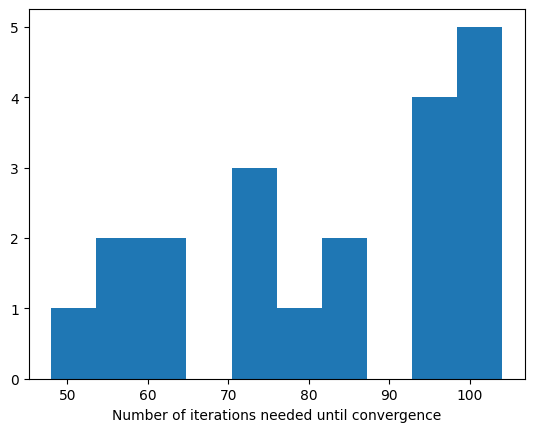

In [8]:
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

(array([ 2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12')])

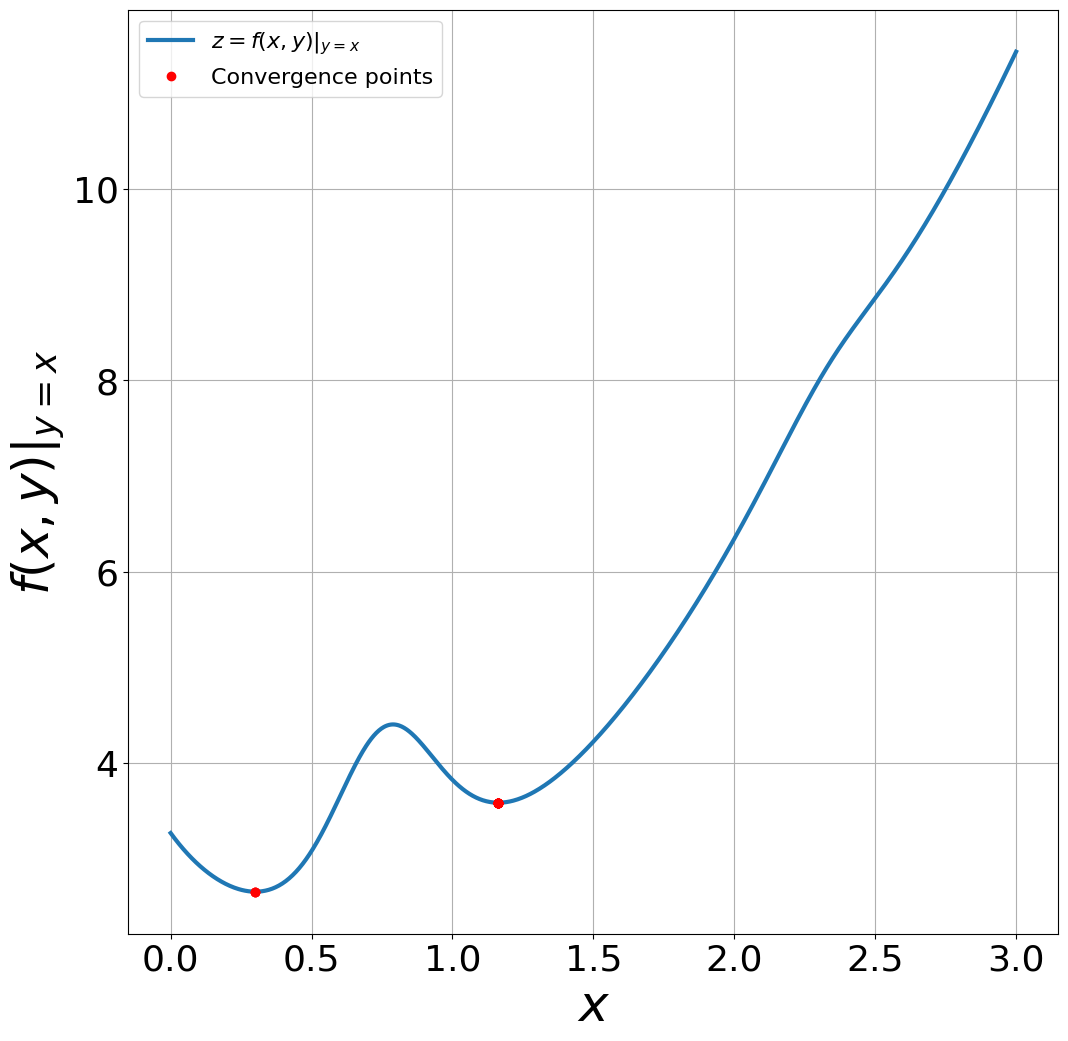

In [9]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12,12))
plt.plot(x_ax, f_np(x_ax,x_ax), linewidth=3)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$z=f(x,y)|_{y=x}$', 'Convergence points'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

Text(0.5, 0.5, '$x$')

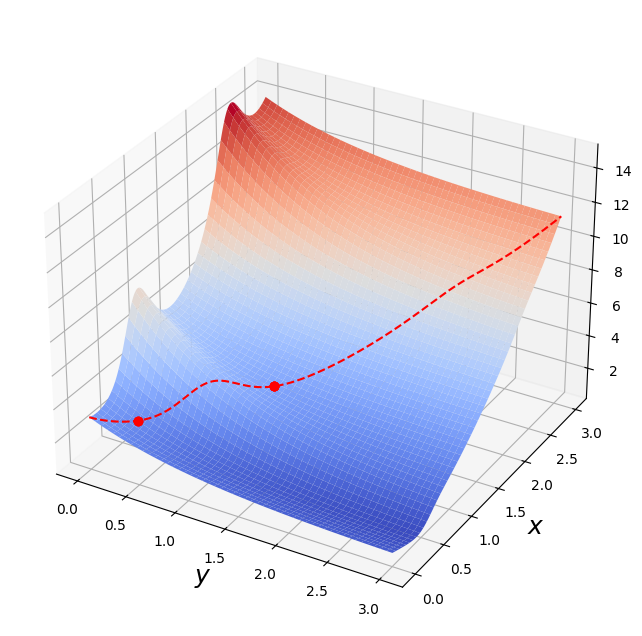

In [10]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)
Z = f_np(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, f_np(Xx, Xx), 'r--', zorder=10)

for i in range(n_jobs):
    ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)

# Toy example 2

In [11]:
def f(x,y):
    return np.exp(-y+2)/(2+np.cos(6*x))+0.5*np.log((4*x-2)**2+1)# + x**2

def f_np(x,y):
    return np.exp(-y+2)/(2+np.cos(6*x))+0.5*np.log((4*x-2)**2+1)# + x**2

def dfx(x,y):
    return 6*math.exp(-y+2)*math.sin(6*x)/((2+math.cos(6*x))**2)+(16*x-8)/((4*x-2)**2+1)# + 2*x

def dfy(x,y):
    return -math.exp(-y+2)/(2+math.cos(6*x))

def df(x,y):
    return np.array([dfx(x,y), dfy(x,y)])

In [12]:
n_jobs = cpu_count()
N = 200
gamma = 5
beta = .1
tau = .1
alpha = .01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gamma, beta, tau, alpha) for i in range(N))

ps = np.array(results)

Text(0.5, 0, 'Number of iterations needed until convergence')

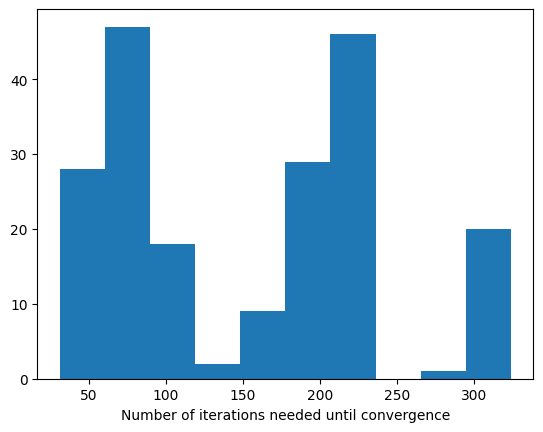

In [13]:
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

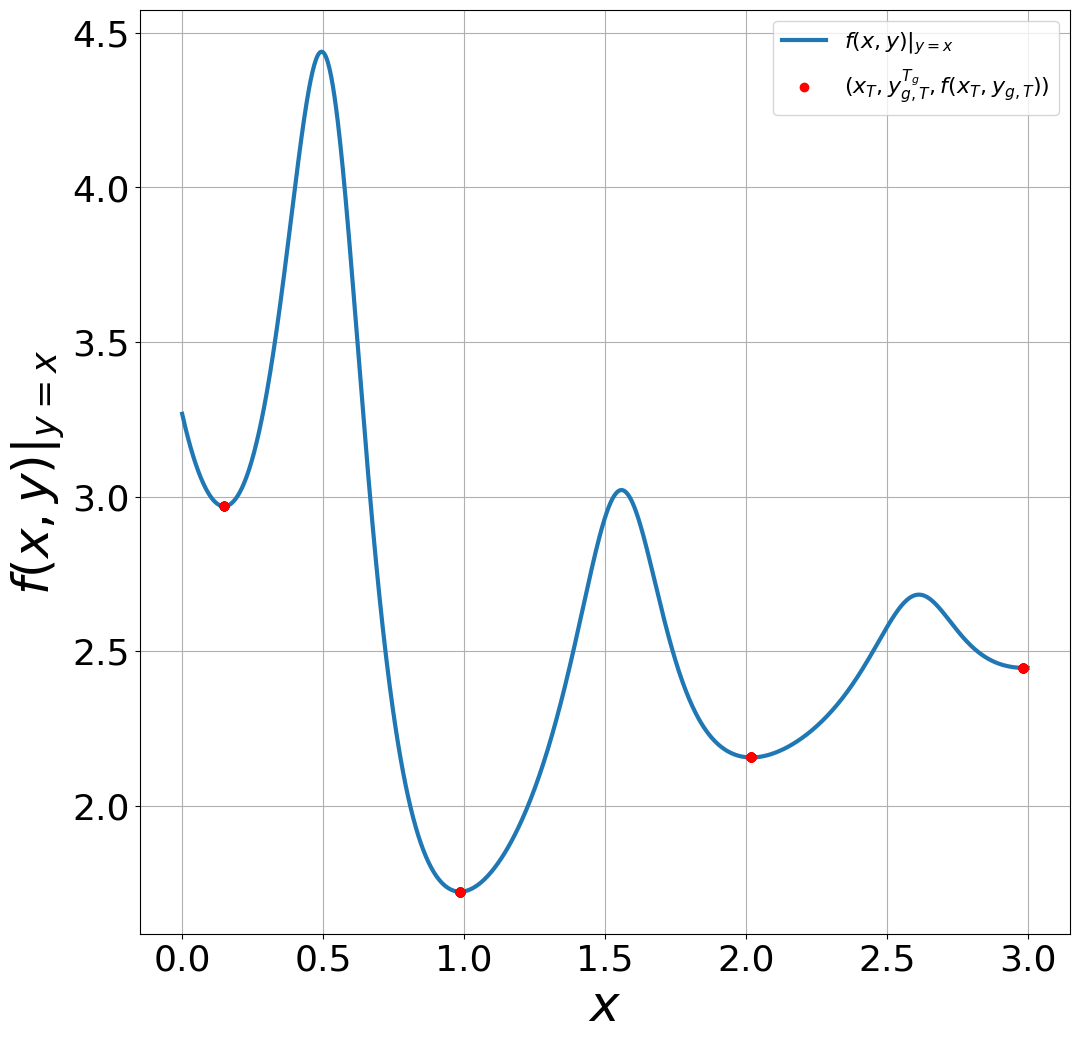

In [14]:
x_ax = np.linspace(0, 3, 1000)

plt.figure(figsize=(12,12))
plt.plot(x_ax, f_np(x_ax,x_ax), linewidth=3)
for i in range(N):
    plt.plot(ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r')

plt.legend(['$f(x,y)|_{y=x}$', '$(x_T, y^{T_g}_{g,T}, f(x_T, y_{g,T}))$'], fontsize=16)
plt.grid()
plt.xlabel('$x$', fontsize=36)
plt.ylabel('$f(x,y)|_{y=x}$', fontsize=36)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.savefig('convergence.pdf')

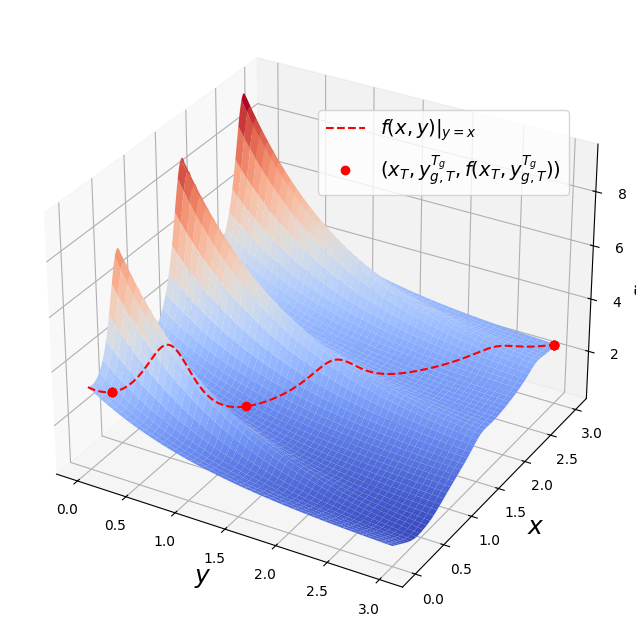

In [15]:
Xx = np.linspace(0,3,1000)
Yy = np.linspace(0,3,1000)
X, Y = np.meshgrid(Xx, Yy)
Z = f_np(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,8))
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot(Xx, Xx, f_np(Xx, Xx), 'r--', zorder=10, label="$f(x,y)|_{y=x}$")

for i in range(n_jobs):
    if i == 1:
        ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10, label="$(x_T, y^{T_g}_{g,T}, f(x_T, y^{T_g}_{g,T}))$")
    else:
        ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', zorder=10)

ax.set_xlabel("$y$", fontsize=18)
ax.set_ylabel("$x$", fontsize=18)
ax.set_zlabel("$f(x,y)$", fontsize=18)

ax.legend(loc=(0.5,0.7), fontsize=14)

plt.savefig('3dplot.pdf', bbox_inches="tight")

# Sensitivity analysis - Gamma

In [16]:
# find all local minima
x_cand = np.linspace(0,3, 10000)
minima = []
for i in range(1,x_cand.shape[0]-1):
    fm1 = f(x_cand[i-1], x_cand[i-1])
    ft = f(x_cand[i], x_cand[i])
    fp1 = f(x_cand[i+1], x_cand[i+1])
    if fm1 > ft and fp1 > ft:
        minima.append(x_cand[i])
minima.append(x_cand[-1])
minima = np.array(minima)
minima

array([0.14881488, 0.98619862, 2.01980198, 2.99069907, 3.        ])

In [17]:
N = 40

In [18]:
gamma_vals = np.logspace(-3, 3, 15)
gamma_vals = np.logspace(-3,0,4)

opt_gaps = np.zeros((gamma_vals.shape[0],N))
errs_mins = np.zeros((gamma_vals.shape[0], N))
exec_times = np.zeros((gamma_vals.shape[0], N))
for i, gam in enumerate(gamma_vals):
    results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(n, gam, beta, tau, alpha) for n in range(N))
    ps = np.array(results)
    opt_gaps[i,:] = np.abs(ps[:,0] - ps[:,1])
    exec_times[i,:] = ps[:,3]
    for n in range(N):
        dists_mins = np.abs(ps[n,0] - minima)
        min_to_use = minima[np.argmin(dists_mins)]
        errs_mins[i,n] = np.abs(f(ps[n,0], ps[n,1]) - f(min_to_use, min_to_use))

Text(0.5, 0, '$\\gamma$')

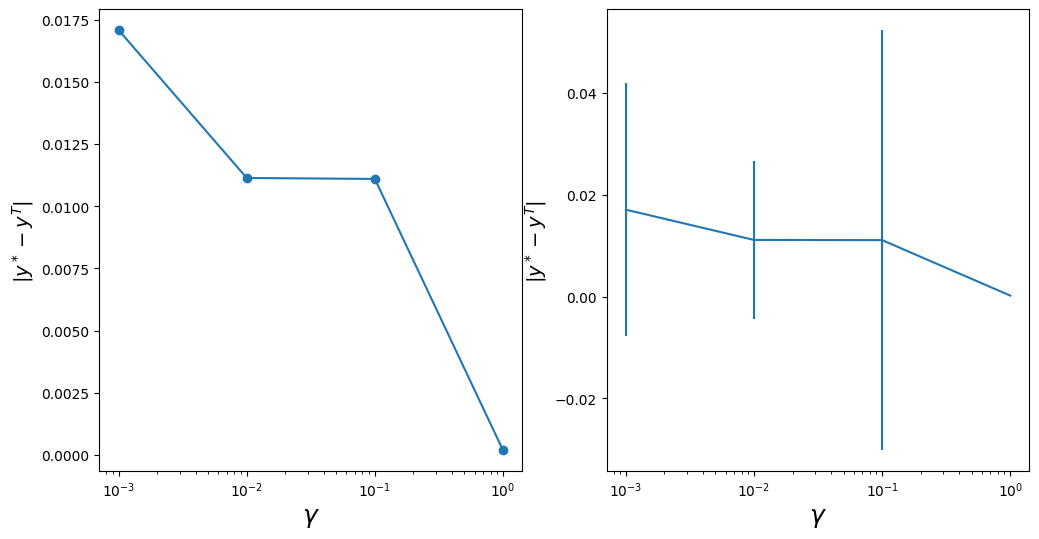

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].semilogx(gamma_vals, opt_gaps.mean(1), 'o-')
ax[0].set_ylabel("$|y^*-y^T|$", fontsize=14)
ax[0].set_xlabel("$\\gamma$", fontsize=18)

ax[1].errorbar(gamma_vals, opt_gaps.mean(1), yerr=opt_gaps.std(1))
ax[1].set_xscale('log')
ax[1].set_ylabel("$|y^*-y^T|$", fontsize=14)
ax[1].set_xlabel("$\\gamma$", fontsize=18)

Text(0.5, 0, '$\\gamma$')

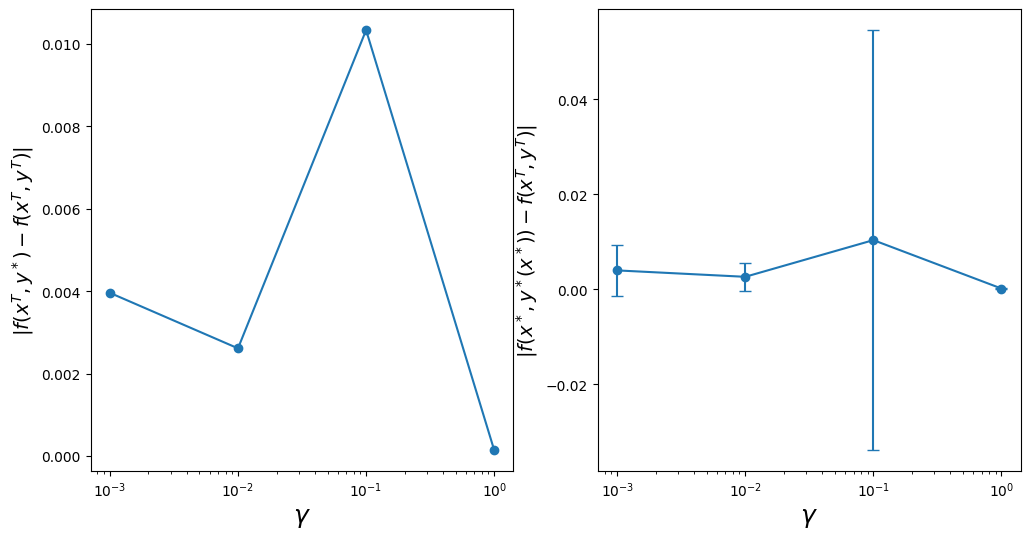

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].semilogx(gamma_vals, errs_mins.mean(1), 'o-')
ax[0].set_ylabel("$|f(x^T, y^*) - f(x^T, y^T)|$", fontsize=14)
ax[0].set_xlabel("$\\gamma$", fontsize=18)

ax[1].errorbar(gamma_vals, errs_mins.mean(1), yerr=errs_mins.std(1), fmt='o', linestyle='-', capsize=4, label='percent', errorevery=1)
#ax[1].boxplot(errs_mins.T)
ax[1].set_xscale('log')
ax[1].set_ylabel("$|f(x^*, y^*(x^*)) - f(x^T, y^T)|$", fontsize=14)
ax[1].set_xlabel("$\\gamma$", fontsize=18)

In [21]:
# Generate LaTeX table
table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|c|" + "c|"*opt_gaps.shape[0] + "}\n"
table += "\\hline\n"
table += "$\\gamma$ & " + " & ".join([f"{gamma_vals[i]:.3f}" for i in range(opt_gaps.shape[0])]) + " \\\\\n"
table += "\\hline\n"

metrics_strs = ["$|y^*-y^T|$", "$|f(x^*, y^*(x^*)) - f(x^T, y^T)|$", "Time"]
for i, metric in enumerate([opt_gaps, errs_mins, exec_times]):
    met_mean = metric.mean(1)
    met_std = metric.std(1)

    # Add opt_gaps row
    table += f"{metrics_strs[i]} & " + " & ".join([f"${mean:.3f} \\pm {std:.3f}$" for mean, std in zip(met_mean, met_std)]) + " \\\\\n"
    table += "\\hline\n"

table += "\\end{tabular}\n\\caption{Simulation Results}\n\\end{table}"

# Print the LaTeX table
print(table)

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
$\gamma$ & 0.001 & 0.010 & 0.100 & 1.000 \\
\hline
$|y^*-y^T|$ & $0.017 \pm 0.025$ & $0.011 \pm 0.016$ & $0.011 \pm 0.041$ & $0.000 \pm 0.000$ \\
\hline
$|f(x^*, y^*(x^*)) - f(x^T, y^T)|$ & $0.004 \pm 0.005$ & $0.003 \pm 0.003$ & $0.010 \pm 0.044$ & $0.000 \pm 0.000$ \\
\hline
Time & $5.888 \pm 5.974$ & $2.881 \pm 3.254$ & $0.961 \pm 0.854$ & $0.777 \pm 0.357$ \\
\hline
\end{tabular}
\caption{Simulation Results}
\end{table}


In [22]:
gamma_vals_ag = np.logspace(-3, 0, 4)
alpha_vals_ag = np.logspace(-3, 1, 5)

opt_gaps_ag = np.zeros((gamma_vals_ag.shape[0], alpha_vals_ag.shape[0], N))
errs_mins_ag = np.zeros((gamma_vals_ag.shape[0], alpha_vals_ag.shape[0], N))
exec_times_ag = np.zeros((gamma_vals_ag.shape[0], alpha_vals_ag.shape[0], N))
for i, gam in enumerate(gamma_vals_ag):
    for j, alph in enumerate(alpha_vals_ag):
        results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(n, gam, beta, tau, alph) for n in range(N))
        ps = np.array(results)
        opt_gaps_ag[i,j,:] = np.abs(ps[:,0] - ps[:,1])
        exec_times_ag[i,j,:] = ps[:,3]
        for n in range(N):
            dists_mins = np.abs(ps[n,0] - minima)
            min_to_use = minima[np.argmin(dists_mins)]
            errs_mins_ag[i,j,n] = np.abs(f(ps[n,0], ps[n,1]) - f(min_to_use, min_to_use))

In [23]:
# Calculate mean and standard deviation for each row
opt_gaps_mean = opt_gaps_ag.mean(axis=2)
opt_gaps_std = opt_gaps_ag.std(axis=2)
errs_mins_mean = errs_mins_ag.mean(axis=2)
errs_mins_std = errs_mins_ag.std(axis=2)

# Generate LaTeX table
table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|c|" + "c|"*opt_gaps.shape[0] + "}\n"
table += "\\hline\n"
table += "\\diagbox{$\\eta$}{$\\gamma$} & " + " & ".join([f"${gamma_vals_ag[i]}$" for i in range(opt_gaps_ag.shape[0])]) + " \\\\\n"
table += "\\hline\n"

for j in range(alpha_vals_ag.shape[0]):
    table += f"${alpha_vals_ag[j]}$ & " + " & ".join([f"${mean:.3f} \\pm {std:.3f}$" for mean, std in zip(opt_gaps_mean[:,j], opt_gaps_std[:,j])]) + " \\\\\n"

table += "\\hline\n\\end{tabular}\n\\caption{Optimality gaps $|y^* - y^T|$}\n\\end{table}"

#table = table.replace(".00", "").replace("e-0", "\\cdot 10^")
#table = re.sub(r'e([+-]?)(0*)(\d+)', r'\\cdot 10^{\1\3}', table.replace(".00", ""))

print(table)

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\diagbox{$\eta$}{$\gamma$} & $0.001$ & $0.01$ & $0.1$ & $1.0$ \\
\hline
$0.001$ & $0.019 \pm 0.030$ & $0.012 \pm 0.023$ & $0.026 \pm 0.081$ & $0.000 \pm 0.000$ \\
$0.01$ & $0.016 \pm 0.022$ & $0.013 \pm 0.019$ & $0.008 \pm 0.018$ & $0.000 \pm 0.000$ \\
$0.1$ & $0.009 \pm 0.015$ & $0.018 \pm 0.030$ & $0.005 \pm 0.008$ & $0.000 \pm 0.000$ \\
$1.0$ & $0.029 \pm 0.029$ & $0.026 \pm 0.018$ & $0.012 \pm 0.017$ & $0.000 \pm 0.000$ \\
$10.0$ & $0.021 \pm 0.025$ & $0.027 \pm 0.042$ & $0.014 \pm 0.022$ & $0.000 \pm 0.000$ \\
\hline
\end{tabular}
\caption{Optimality gaps $|y^* - y^T|$}
\end{table}


In [26]:
# Calculate mean and standard deviation for each row
errs_mins_mean = errs_mins_ag.mean(axis=2)
errs_mins_std = errs_mins_ag.std(axis=2)
errs_mins_mean = errs_mins_ag.mean(axis=2)
errs_mins_std = errs_mins_ag.std(axis=2)

# Generate LaTeX table
table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|c|" + "c|"*errs_mins.shape[0] + "}\n"
table += "\\hline\n"
table += "\\diagbox{$\\eta$}{$\\gamma$} & " + " & ".join([f"${gamma_vals_ag[i]}$" for i in range(errs_mins_ag.shape[0])]) + " \\\\\n"
table += "\\hline\n"

for j in range(alpha_vals_ag.shape[0]):
    table += f"${alpha_vals_ag[j]}$ & " + " & ".join([f"${mean:.3f} \\pm {std:.3f}$" for mean, std in zip(errs_mins_mean[:,j], opt_gaps_std[:,j])]) + " \\\\\n"

table += "\\hline\n\\end{tabular}\n\\caption{Optimality gaps}\n\\end{table}"

#table = table.replace(".00", "").replace("e-0", "\\cdot 10^")
#table = re.sub(r'e([+-]?)(0*)(\d+)', r'\\cdot 10^{\1\3}', table.replace(".00", ""))

print(table)

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\diagbox{$\eta$}{$\gamma$} & $0.001$ & $0.01$ & $0.1$ & $1.0$ \\
\hline
$0.001$ & $0.004 \pm 0.030$ & $0.004 \pm 0.023$ & $0.012 \pm 0.081$ & $0.003 \pm 0.000$ \\
$0.01$ & $0.005 \pm 0.022$ & $0.004 \pm 0.019$ & $0.002 \pm 0.018$ & $0.000 \pm 0.000$ \\
$0.1$ & $0.079 \pm 0.015$ & $0.145 \pm 0.030$ & $0.063 \pm 0.008$ & $0.072 \pm 0.000$ \\
$1.0$ & $0.004 \pm 0.029$ & $0.004 \pm 0.018$ & $0.003 \pm 0.017$ & $0.000 \pm 0.000$ \\
$10.0$ & $0.106 \pm 0.025$ & $0.062 \pm 0.042$ & $0.035 \pm 0.022$ & $0.063 \pm 0.000$ \\
\hline
\end{tabular}
\caption{Optimality gaps}
\end{table}


In [25]:
# Calculate mean and standard deviation for each row
exec_times_mean = exec_times_ag.mean(axis=2)
exec_times_std = exec_times_ag.std(axis=2)
errs_mins_mean = errs_mins_ag.mean(axis=2)
errs_mins_std = errs_mins_ag.std(axis=2)

# Generate LaTeX table
table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{|c|" + "c|"*exec_times.shape[0] + "}\n"
table += "\\hline\n"
table += "\\diagbox{$\\eta$}{$\\gamma$} & " + " & ".join([f"${gamma_vals_ag[i]}$" for i in range(exec_times_ag.shape[0])]) + " \\\\\n"
table += "\\hline\n"

for j in range(alpha_vals_ag.shape[0]):
    table += f"${alpha_vals_ag[j]}$ & " + " & ".join([f"${mean:.3f} \\pm {std:.3f}$" for mean, std in zip(exec_times_mean[:,j], opt_gaps_std[:,j])]) + " \\\\\n"

table += "\\hline\n\\end{tabular}\n\\caption{Execution times}\n\\end{table}"

#table = table.replace(".00", "").replace("e-0", "\\cdot 10^")
#table = re.sub(r'e([+-]?)(0*)(\d+)', r'\\cdot 10^{\1\3}', table.replace(".00", ""))

print(table)

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\diagbox{$\eta$}{$\gamma$} & $0.001$ & $0.01$ & $0.1$ & $1.0$ \\
\hline
$0.001$ & $4.152 \pm 0.030$ & $4.112 \pm 0.023$ & $2.083 \pm 0.081$ & $1.884 \pm 0.000$ \\
$0.01$ & $3.231 \pm 0.022$ & $2.743 \pm 0.019$ & $0.978 \pm 0.018$ & $0.477 \pm 0.000$ \\
$0.1$ & $3.709 \pm 0.015$ & $4.186 \pm 0.030$ & $0.593 \pm 0.008$ & $0.535 \pm 0.000$ \\
$1.0$ & $8.707 \pm 0.029$ & $8.017 \pm 0.018$ & $3.192 \pm 0.017$ & $1.599 \pm 0.000$ \\
$10.0$ & $6.381 \pm 0.025$ & $4.685 \pm 0.042$ & $2.668 \pm 0.022$ & $1.692 \pm 0.000$ \\
\hline
\end{tabular}
\caption{Execution times}
\end{table}
